# Data format (input/output data)

In this procject, we mainly deal with two types of data format:

* Waveform: 16/32-bit PCM or 32-bit float WAV that can be read by [scipy.io.wavfile.read](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html)

* Binary data: binary, float-32bit, litten endian ([numpy dtype <f4](https://numpy.org/doc/1.18/reference/generated/numpy.dtype.html)) 

Within this Pytorch script, waveform data, either PCM or float format, will be loaded and converted to float-32 data array. Generated waveform data will be written as 16-bit PCM (by default). There are two functions to [read](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/wav_tools.py#L103) and [write](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/wav_tools.py#L126). They are just simple wrappers over scipy.io.wavfile. 

Here we mainly talk about binary data format, which is raw and not self-explained.

### 1. Write binary data

We use Numpy interface to write and read binary data. Let's first create a numpy array and write to an external file

In [32]:
import numpy as np

data = np.asarray([[1, 2, 3],[4, 5, 6],[7, 8, 9],[10, 11, 12],[13, 14, 15]], dtype=np.float32)
f = open('data_models/temp_data.bin','wb')
datatype = np.dtype('<f4')
data.astype(datatype).tofile(f,'')
f.close()

print(data)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15.]]


### 2. Read binary data
Now we can read data using numpy

In [33]:
f = open('data_models/temp_data.bin','rb')
datatype = np.dtype('<f4')
data_read = np.fromfile(f,dtype=datatype)
f.close()
print(data_read)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


Notice that the data shape is no longer in \[5, 3\]

Also notice that I normally use [c_continuous format](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flags.html) (row-major) when storing the data in external file: data\[0, 0\], data\[0, 1\], data\[0, 2\], data\[1, 0\], data\[1, 1\], data\[1, 2\] ...

In [34]:
data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

Thus, to recover the original shape of data, we need to know how many columns the original data has. 

In [35]:
f = open('data_models/temp_data.bin','rb')
col_num = 3
datatype = np.dtype(('<f4', (col_num, )))
data_read = np.fromfile(f,dtype=datatype)
f.close()
print(data_read)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15.]]


Here are wrapper functions over numpy API to read and write binary data. See this [reader function](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/io_tools.py#L19) and [writer function](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/io_tools.py#L143) in the Pytorch scripts.

Or, you can use *read_raw_mat* and *write_raw_mat* in tool_lib.py in this directory. 

You will see examples of using these two functions later.

### 3. Read some real speech data

Here I use read_raw_mat in tool_lib.py to read a Mel-spectrogram file and an F0 file.

Text(0.5, 1.0, '1st dimension of Mel-spectrogram')

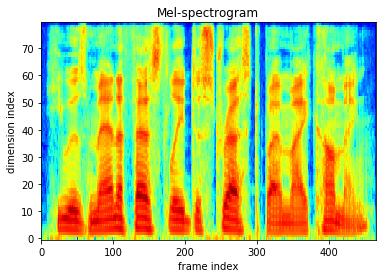

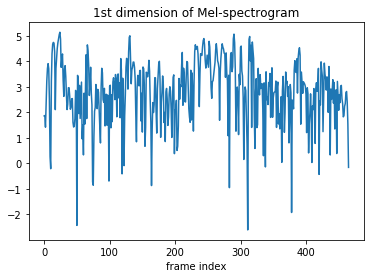

In [41]:
import tool_lib

mel_dimension = 80
mel_data = tool_lib.read_raw_mat('data_models/acoustic_features/bdl_arctic_b0474.mfbsp', mel_dimension)

fig = plt.figure()
axis = fig.add_subplot(111)
axis.imshow(mel_data.T, aspect='auto', origin='lower', cmap='jet')
axis.set_xlabel("frame index")
axis.set_ylabel("dimension index")
axis.set_title("Mel-spectrogram")


fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(mel_data[:, 0])
axis.set_xlabel("frame index")
axis.set_title("1st dimension of Mel-spectrogram")

Text(0.5, 1.0, 'F0 trajectory')

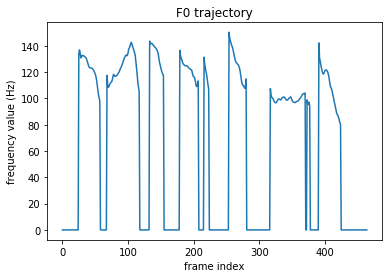

In [38]:

f0_dimension = 1
f0_data = tool_lib.read_raw_mat('data_models/acoustic_features/bdl_arctic_b0474.f0', f0_dimension)

fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(f0_data)
axis.set_xlabel("frame index")
axis.set_ylabel("frequency value (Hz)")
axis.set_title("F0 trajectory")

In [40]:
print("Mel-spectrogram data shape" + str(mel_data.shape))
print("F0 data shape" + str(f0_data.shape))

Mel-spectrogram data shape(466, 80)
F0 data shape(465,)


Notice that mel_data has shape (466, 80), where 466 denotes the number of frames and 80 denotes the feature dimension in each frame.

Notice that f0_data has shape (465,), where 465 denotes the number of frames.

The above examples shows the conventions in this Pytorch project: 

1. 2D data is in shape \[N, M\], where N denotes the frame number and M denotes the feature dimension in each frame

2. 1D data is in shape \[N\], where N denotes the frame number

In practise, please just use the read_raw_mat and write_raw_mat to read and write binary data

### 4. Number of frames

In previous examples, the Mel-spectrogram has 466 frames while the F0 has 465 frames. This difference is mainly caused by the tools extracting Mel-spectrogram and F0. 

In this Pytorch script, the [default data loader](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/default_data_io.py) will handle the mis-match of the frame number in different input features of the same utterance. No need to worry about it.

### 5. Summary

In summary, we assume the following conventions:

1. raw data is saved as binary, float32, little-endian format
2. raw data is read as c-continuous (row-major) matrix
3. raw data in shape [N, M], where N denotes number of frames / time steps, and M denotes feature dimension per time step
4. raw data in shape [N], if M=1